<a href="https://colab.research.google.com/github/Legfi/Reinforcement-learning-in-stock-market/blob/main/Reinforcement_learning_in_stock_market(costume_environment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Necessary libraries

In [1]:
!pip install yfinance stable-baselines3 shimmy>=0.2.1

In [7]:
# Import necessary libraries

# dowloading data
import yfinance as yf

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Gym stuff
import gymnasium as gym

# Stable baselines - rl stuff
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

##Getting data:

In [3]:
bitcoin_data = yf.download('BTC-USD', start='2017-01-01')

# dropping the adj column as it's a the same column as close
Bitcoine_data_plot = bitcoin_data.drop(['Adj Close'], axis=1)
bitcoin_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


##I needed to make two data set one for ploting perposes where date is a cloumn and the other one for RL where date is an index column

In [14]:
# reseting index to have date as column for ploting purposes
Bitcoine_data_plot.reset_index(inplace=True)
Bitcoine_data_plot.head()

,index,Date,Open,High,Low,Close,Volume
0,0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
1,1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2,2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
3,3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
4,4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008


In [5]:
Bitcoine_data_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2653 non-null   datetime64[ns]
 1   Open    2653 non-null   float64       
 2   High    2653 non-null   float64       
 3   Low     2653 non-null   float64       
 4   Close   2653 non-null   float64       
 5   Volume  2653 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 124.5 KB


##Defining the costume environment using gym

In [15]:
class BitcoinTradingEnvironment(gym.Env):
    def __init__(self, data):
        super(BitcoinTradingEnvironment, self).__init__()
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # 3 actions: Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 1.0  # Start with $1.0
        self.num_coins_held = 0
        self.net_worth = 1.0
        self.max_steps = len(self.data) - 1
        return self._get_observation()

    def _get_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self.current_step += 1
        if self.current_step > self.max_steps:
            raise StopIteration("End of data")

        # Execute action (Buy, Sell, Hold)
        current_price = self.data.iloc[self.current_step]['Close']
        previous_price = self.data.iloc[self.current_step - 1]['Close']

        if action == 0:  # Buy
            if self.balance > 0:  # Make sure balance is positive
                coins_bought = self.balance / current_price
                self.num_coins_held += coins_bought
                self.balance -= coins_bought * current_price
        elif action == 1:  # Sell
            if self.num_coins_held > 0:  # Make sure there are coins to sell
                self.balance += self.num_coins_held * current_price
                self.num_coins_held = 0
        else:  # Hold
            pass  # Do nothing

        # Update balance, num_coins_held, and net_worth
        self.net_worth = self.balance + self.num_coins_held * current_price

        # Calculate reward based on the action taken
        reward = self.net_worth - 1.0  # Reward is the change in net worth relative to the initial balance

        # Update state
        obs = self._get_observation()

        return obs, reward, False, {}

    def render(self, mode='human', close=False):
        pass  # Implement visualization of the environment if needed

# Create environment instance
env = BitcoinTradingEnvironment(bitcoin_data)


##Passing data to environment, taking 100 random action and ploting it to see how the envirement works!

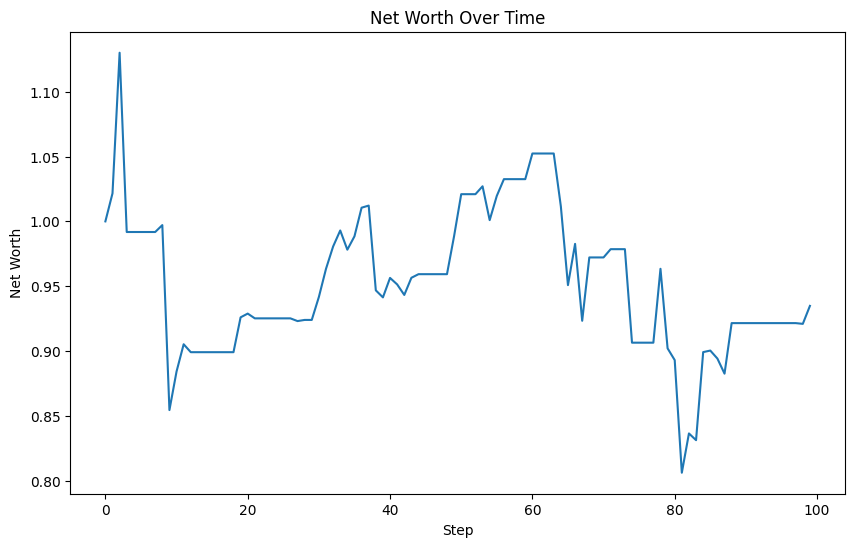

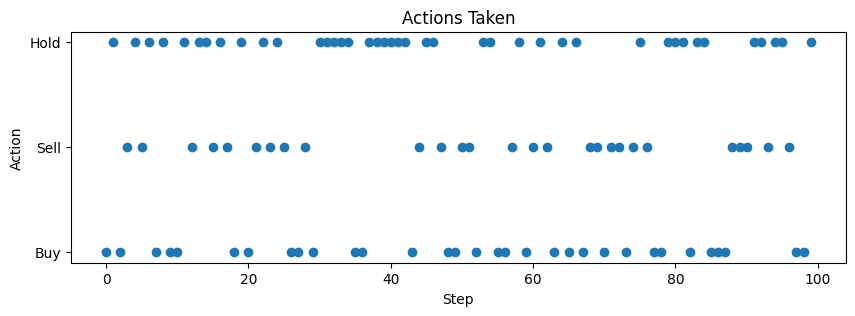

In [16]:
# Create an instance of BitcoinTradingEnvironment
env = BitcoinTradingEnvironment(Bitcoine_data_plot)

# Initialize lists to store net worth and actions
net_worth_history = []
actions_history = []

# Reset the environment
obs = env.reset()

# Take 100 random actions and record net worth and actions
for _ in range(100):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, _ = env.step(action)
    net_worth_history.append(env.net_worth)
    actions_history.append(action)

# Visualize net worth over time
plt.figure(figsize=(10, 6))
plt.plot(net_worth_history)
plt.title('Net Worth Over Time')
plt.xlabel('Step')
plt.ylabel('Net Worth')
plt.show()

# Visualize actions taken
plt.figure(figsize=(10, 3))
plt.plot(actions_history, marker='o', linestyle='None')
plt.title('Actions Taken')
plt.xlabel('Step')
plt.ylabel('Action')
plt.yticks(range(3), ['Buy', 'Sell', 'Hold'])
plt.show()


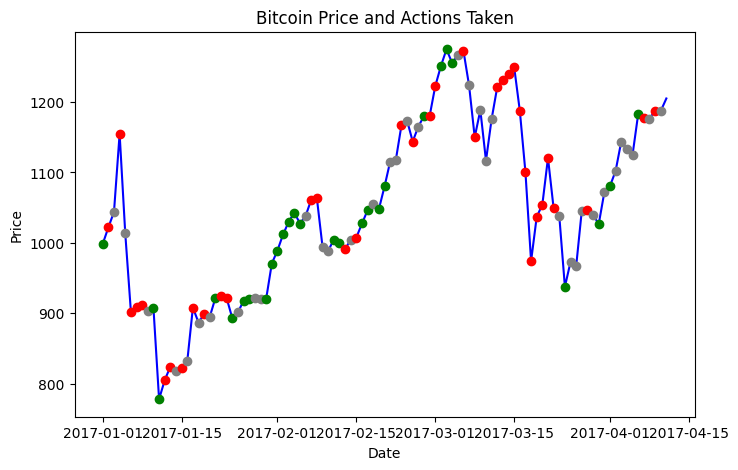

Net worth: $1.6720545499598374
Profit/Loss Percentage: 67.21%


In [17]:
# Create an instance of BitcoinTradingEnvironment
env = BitcoinTradingEnvironment(Bitcoine_data_plot)

# Initialize lists to store net worth and actions
net_worth_history = []
actions_history = []

# Reset the environment
obs = env.reset()

# Take 100 random actions and record net worth and actions
for _ in range(100):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, _ = env.step(action)
    net_worth_history.append(env.net_worth)
    actions_history.append(action)

# Plot Bitcoin price data
plt.figure(figsize=(8, 5))
plt.plot(Bitcoine_data_plot['Date'][:101], Bitcoine_data_plot['Close'][:101], label='Bitcoin Price', color='blue')

# Plot actions taken
for i, action in enumerate(actions_history):
    if action == 0:  # Buy
        plt.plot(Bitcoine_data_plot.iloc[i]['Date'], Bitcoine_data_plot.iloc[i]['Close'], marker='o', color='green', label='Buy')
    elif action == 1:  # Sell
        plt.plot(Bitcoine_data_plot.iloc[i]['Date'], Bitcoine_data_plot.iloc[i]['Close'], marker='o', color='red', label='Sell')
    else:  # Hold
        plt.plot(Bitcoine_data_plot.iloc[i]['Date'], Bitcoine_data_plot.iloc[i]['Close'], marker='o', color='gray', label='Hold')

# Display net worth and calculate profit/loss percentage
net_worth = net_worth_history[-1]
initial_balance = 1.0  # Initial balance
profit_loss_percentage = ((net_worth - initial_balance) / initial_balance) * 100

plt.title('Bitcoin Price and Actions Taken')
plt.xlabel('Date')
plt.ylabel('Price')
#plt.legend()
plt.show()

# Print net worth and profit/loss percentage
print(f'Net worth: ${net_worth}')
print(f'Profit/Loss Percentage: {profit_loss_percentage:.2f}%')


##Now instead of random action we want to train a RL model

In [ ]:
# Create an instance of BitcoinTradingEnvironment
env = BitcoinTradingEnvironment(bitcoin_data)

# Wrap the environment in a VecEnv
env = DummyVecEnv([lambda: env])

# Define and train the RL model (PPO in this case)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)  # You may adjust the number of training steps as needed

# Save the trained model
model.save("bitcoin_trading_model")

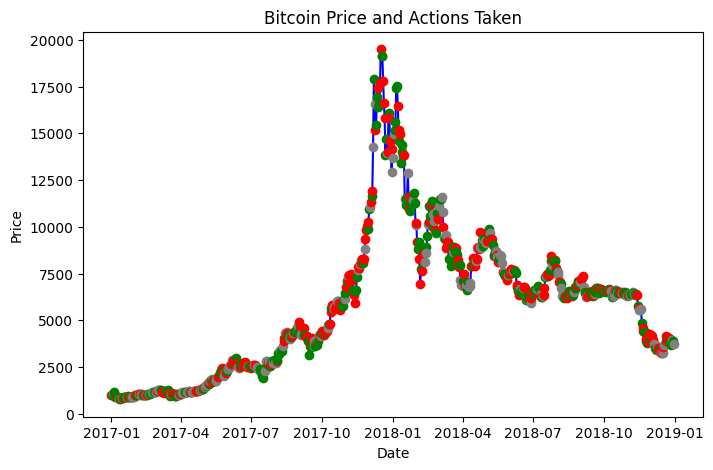

Net worth: $3.286019107117797
Profit/Loss Percentage: 228.60%


In [ ]:
obs = env.reset()
net_worth_history = []
actions_history = []

for _ in range(730):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    net_worth_history.append(env.envs[0].net_worth)
    actions_history.append(action)

# Plot Bitcoin price data
plt.figure(figsize=(8, 5))
plt.plot(Bitcoine_data_plot['Date'][:731], Bitcoine_data_plot['Close'][:731], label='Bitcoin Price', color='blue')

# Plot actions taken
for i, action in enumerate(actions_history):
    if action == 0:  # Buy
        plt.plot(Bitcoine_data_plot.iloc[i]['Date'], Bitcoine_data_plot.iloc[i]['Close'], marker='o', color='green', label='Buy')
    elif action == 1:  # Sell
        plt.plot(Bitcoine_data_plot.iloc[i]['Date'], Bitcoine_data_plot.iloc[i]['Close'], marker='o', color='red', label='Sell')
    else:  # Hold
        plt.plot(Bitcoine_data_plot.iloc[i]['Date'], Bitcoine_data_plot.iloc[i]['Close'], marker='o', color='gray', label='Hold')

# Display net worth and calculate profit/loss percentage
net_worth = net_worth_history[-1]
initial_balance = 1.0  # Initial balance
profit_loss_percentage = ((net_worth - initial_balance) / initial_balance) * 100

plt.title('Bitcoin Price and Actions Taken')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Print net worth and profit/loss percentage
print(f'Net worth: ${net_worth}')
print(f'Profit/Loss Percentage: {profit_loss_percentage:.2f}%')